In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import scipy.stats as stats
import seaborn as sns
from functions import *
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, validation_curve,cross_val_score,GridSearchCV
from sklearn.metrics import plot_confusion_matrix



%matplotlib inline

In [2]:
openfood=pd.read_csv('clean.csv',sep='\t')
numeric=['fiber_100g','proteins_100g','salt_100g','energy_100g','sugars_100g','saturated-fat_100g','carbohydrates_100g','fat_100g','sodium_100g']
openfood.shape

(61404, 12)

In [3]:
openfood[openfood['nutrition_grade_fr'] == 'a']

,code,nutrition_grade_fr,nutrition-score-fr_100g,salt_100g,energy_100g,sugars_100g,saturated-fat_100g,carbohydrates_100g,fat_100g,sodium_100g,fiber_100g,proteins_100g
19,13628,a,-2.0,0.75,619.0,2.9,0.7,27.375473,11.472027,0.295276,1.1,8.4
36,73455,a,-4.0,0.25,354.0,2.7,0.6,7.800000,1.600000,0.098425,1.3,8.9
38,80910,a,-4.0,0.63,619.0,0.6,1.6,27.375473,11.472027,0.248031,2.7,8.9
40,83164,a,-3.0,0.60,586.0,0.5,1.4,16.200000,3.800000,0.236220,1.5,9.3
42,90100,a,-4.0,0.63,622.0,0.5,2.0,16.000000,4.400000,0.248031,2.2,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...
61339,94002935,a,-2.0,0.00,1339.0,9.0,1.0,27.375473,11.472027,0.000000,10.0,2.0
61346,9501006300039,a,-5.0,0.01,206.0,9.7,0.0,10.400000,0.000000,0.003937,1.9,0.6
61348,9501006900086,a,-1.0,0.76,89.0,0.2,0.0,1.400000,0.000000,0.299213,2.5,2.3
61350,9546549536453,a,-4.0,0.10,305.0,3.8,1.3,27.375473,11.472027,0.039370,0.0,9.9


# Analyse univariée des variables

Dans cette partie je vais effectuer une analyse univariée de mes variables afin d’étudier leurs comportement, puis étudier les différentes corrélations entre celles-ci. 

<AxesSubplot:>

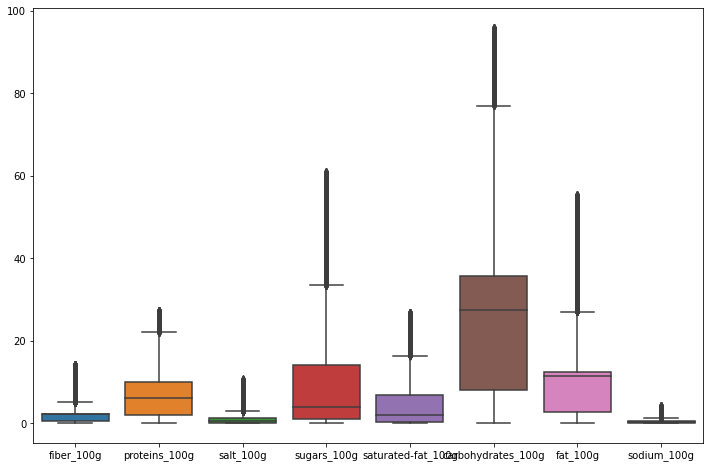

In [4]:

fig, ax = plt.subplots(1, 1,figsize=(12,8))
sns.boxplot(data=openfood[np.delete(numeric,3)])

La variance de l'energie est
627083.863075676


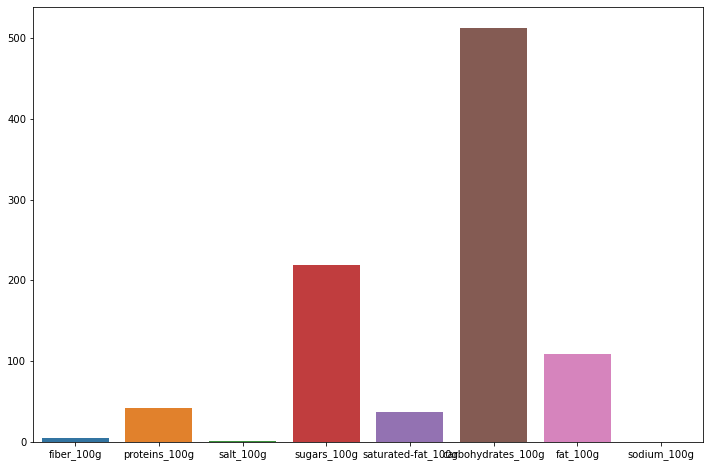

In [5]:
#Variance de chaque variable
fig, ax = plt.subplots(1, 1,figsize=(12,8))
sns.barplot(x=openfood[np.delete(numeric,3)].var().index,y=openfood[np.delete(numeric,3)].var().values)
print("La variance de l'energie est")
print(openfood['energy_100g'].var())

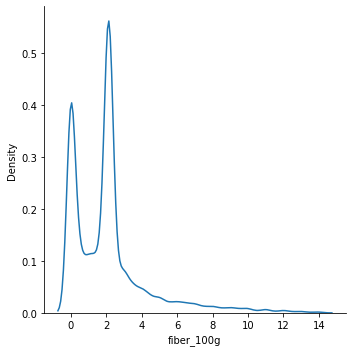

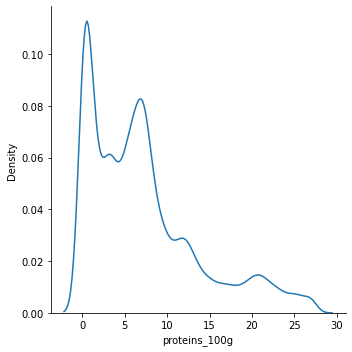

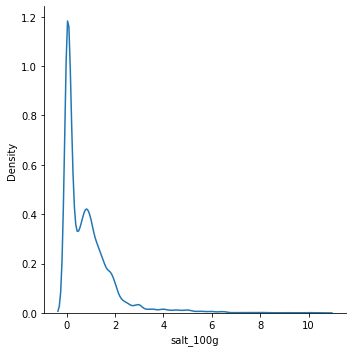

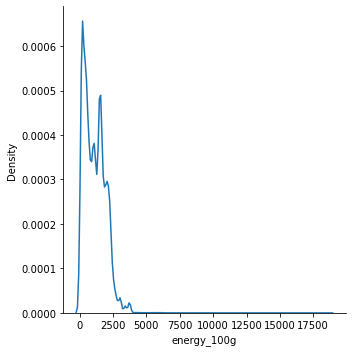

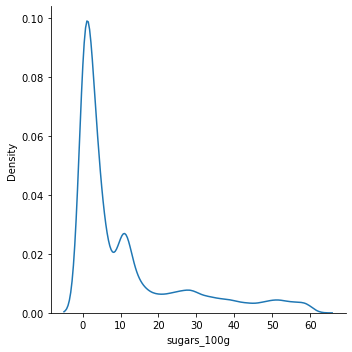

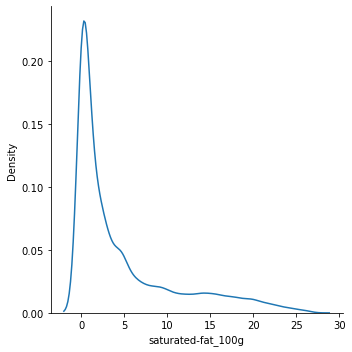

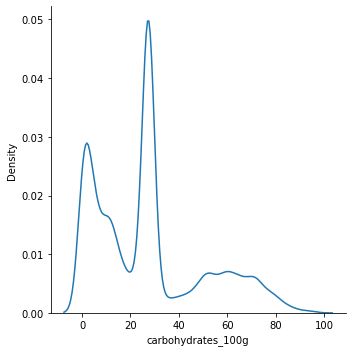

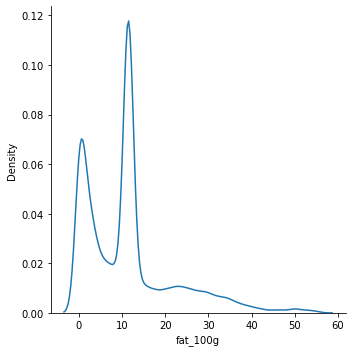

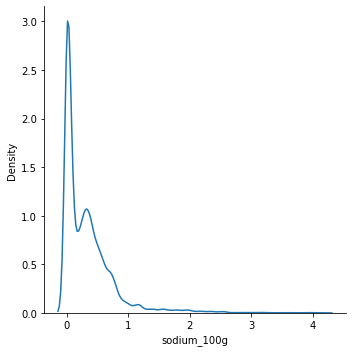

In [6]:
#Densité de chaque variable
for col in numeric:
    sns.displot(x=col,data=openfood, kind="kde")

([<matplotlib.patches.Wedge at 0x276cb498d90>,
 [Text(0.9530778603943323, 0.5492199850935523, 'a'),
  Text(0.060132214535005044, 1.0983551869842088, 'b'),
  Text(-0.9754562576522555, 0.5084142891452369, 'c'),
  Text(-0.5348715316932219, -0.9612036436594209, 'd'),
  Text(0.9048812147718345, -0.6254518264047595, 'e')],
 [Text(0.5198606511241812, 0.2995745373237558, '17%'),
  Text(0.032799389746366384, 0.5991028292641138, '15%'),
  Text(-0.5320670496285029, 0.27731688498831103, '21%'),
  Text(-0.2917481081963028, -0.5242928965415022, '28%'),
  Text(0.4935715716937278, -0.34115554167532336, '19%')])

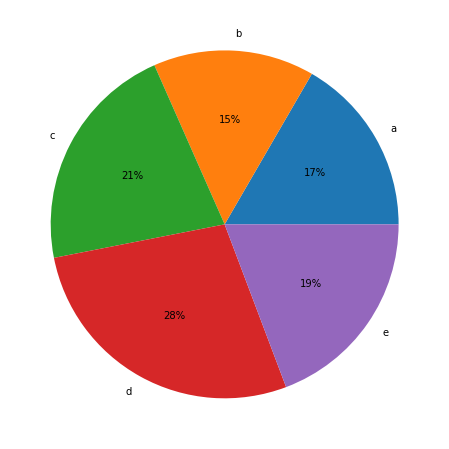

In [7]:
#Repartion globales des grades nutritionnels
data=openfood.groupby('nutrition_grade_fr').count()
labels=data.index
value=data['code'].values
fig, ax = plt.subplots(1, 1,figsize=(12,8))
plt.pie(value,labels=labels,autopct='%.0f%%')

# Analyse multivariée des variables

Pour l'analyse multivariée des mes variables, je vais etudier les corrélations entre les differentes valeurs numériques de mon DataFrame
Puis je vais effectuer une etude Anova pour determiner la corrélation entre les variables et le grade de nutrition

## Analyse des corrélations


<AxesSubplot:>

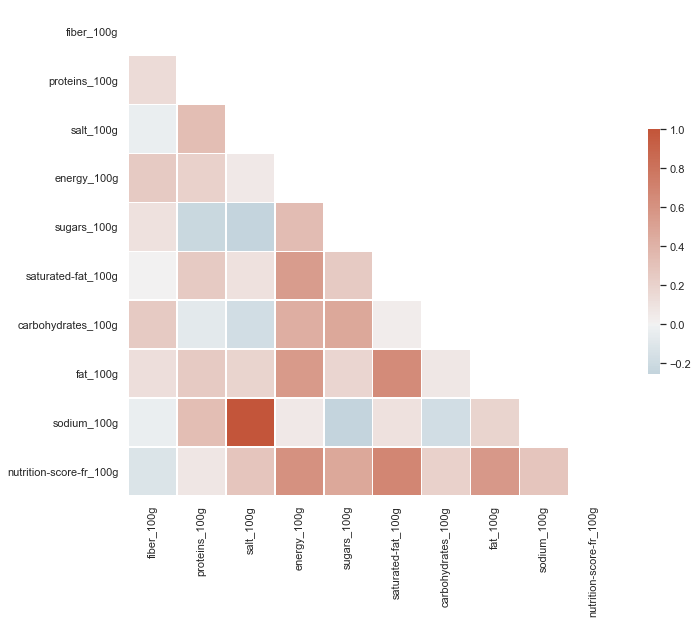

In [8]:
sns.set_theme(style="white")
test=numeric+['nutrition-score-fr_100g']


#Creation d'une heatmap des corrélations
corr = openfood[test].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# anova

In [9]:
X = "categ" # qualitative
Y = "montant" # quantitative

    
result=stats.f_oneway(openfood[numeric][openfood['nutrition_grade_fr'] == 'a'],
               openfood[numeric][openfood['nutrition_grade_fr'] == 'b'],
               openfood[numeric][openfood['nutrition_grade_fr'] == 'c'],
               openfood[numeric][openfood['nutrition_grade_fr'] == 'd'],
               openfood[numeric][openfood['nutrition_grade_fr'] == 'e'])

pd.DataFrame({'variables' : numeric,
            'nvalue': result[0],
            'pvalue': result[1] })









,variables,nvalue,pvalue
0,fiber_100g,794.266044,0.000000e+00
1,proteins_100g,279.807352,7.795414e-239
2,salt_100g,1301.276299,0.000000e+00
3,energy_100g,6965.732187,0.000000e+00
4,sugars_100g,3563.506977,0.000000e+00
5,saturated-fat_100g,10251.716863,0.000000e+00
6,carbohydrates_100g,612.328733,0.000000e+00
7,fat_100g,5031.524852,0.000000e+00
8,sodium_100g,1301.280001,0.000000e+00


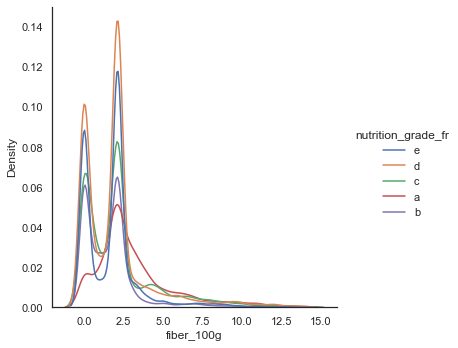

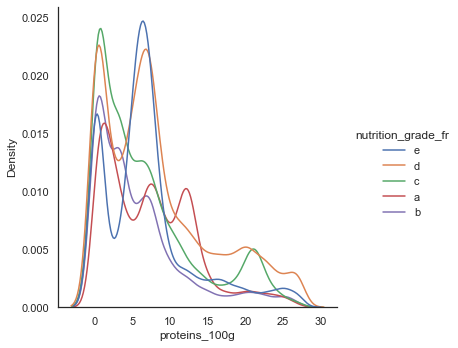

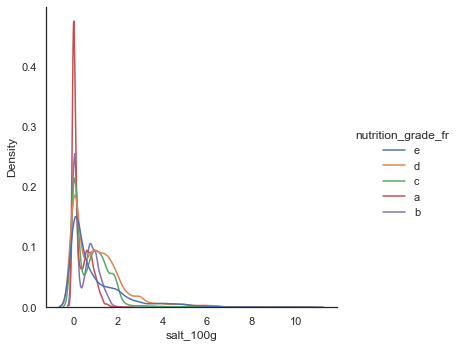

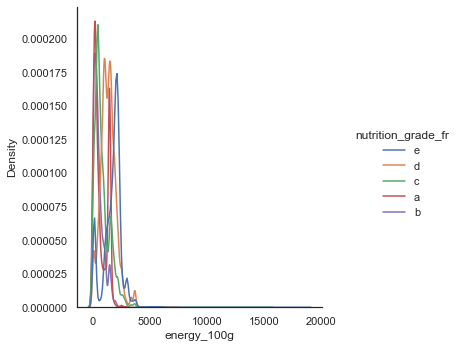

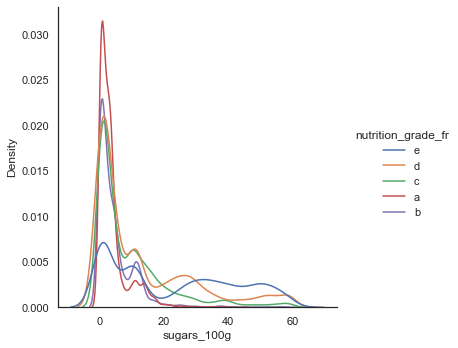

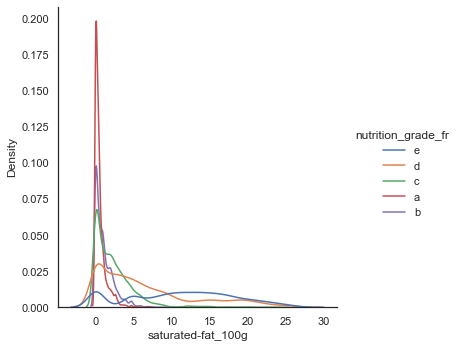

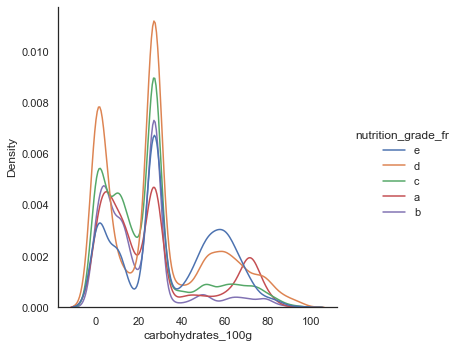

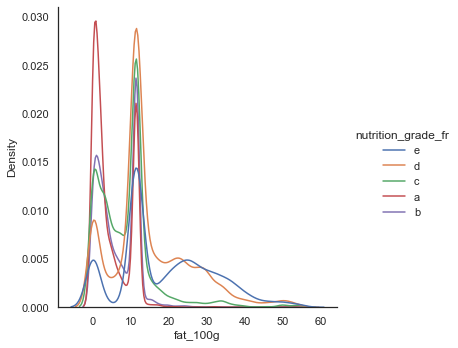

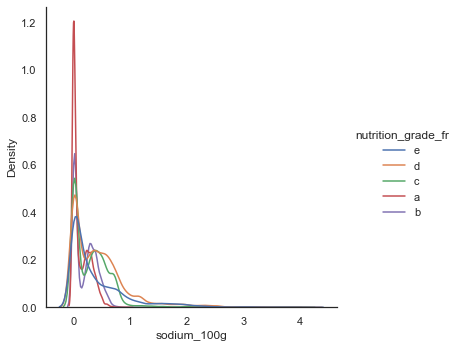

In [10]:
#Densité des variables selon leur grade nutritionnel
for col in numeric:
    sns.displot(x=col,data=openfood,hue="nutrition_grade_fr", kind="kde")

# Reduction de dimension

Je vais effectuer ma reduction de dimension a l'aide d'une ACP

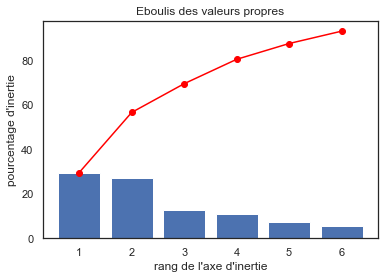

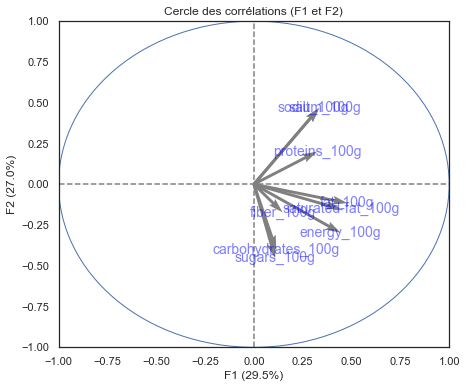

In [11]:
# choix du nombre de composantes à calculer
n_comp = 6

# import de l'échantillon
data = openfood[numeric]

# selection des colonnes à prendre en compte dans l'ACP
data_pca = data[numeric]

# préparation des données pour l'ACP
X = data_pca.values
names = data.index # ou data.index pour avoir les intitulés
features = data.columns

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

# Eboulis des valeurs propres
display_scree_plot(pca)

# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, 3, pca, [(0,1),(2,3),(4,5)], labels = np.array(features))



plt.show()

Je choisi de garder seulement les deux premiers axes d'inertie pour la suite, la axes suivant n'apportant plus suffisement d'information

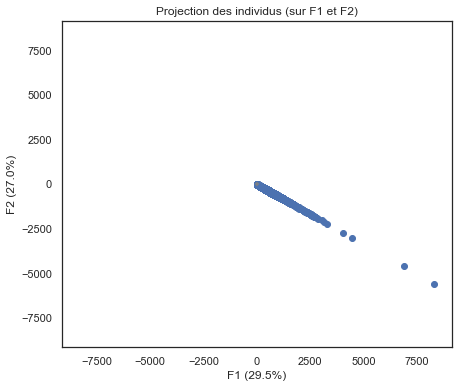

In [12]:
# Projection des individus
X_projected = pca.transform(X)
display_factorial_planes(X_projected,3, pca, [(0,1)])

plt.show()

In [13]:
# J'inclue les nouvelle variables dans mon Dataframe
openfood[['F1','F2']]=X_projected[:,[0,1]]

#Je retire les quelques valeurs abberantes ressortants
for col in ['F1','F2']:
    means=openfood[col].mean()
    stds=openfood[col].std()
    openfood[col]=openfood[col].map(lambda v: np.NaN if abs((v-means)/stds) > 3 else v,na_action='ignore')
    openfood=openfood.dropna(subset=[col])
    

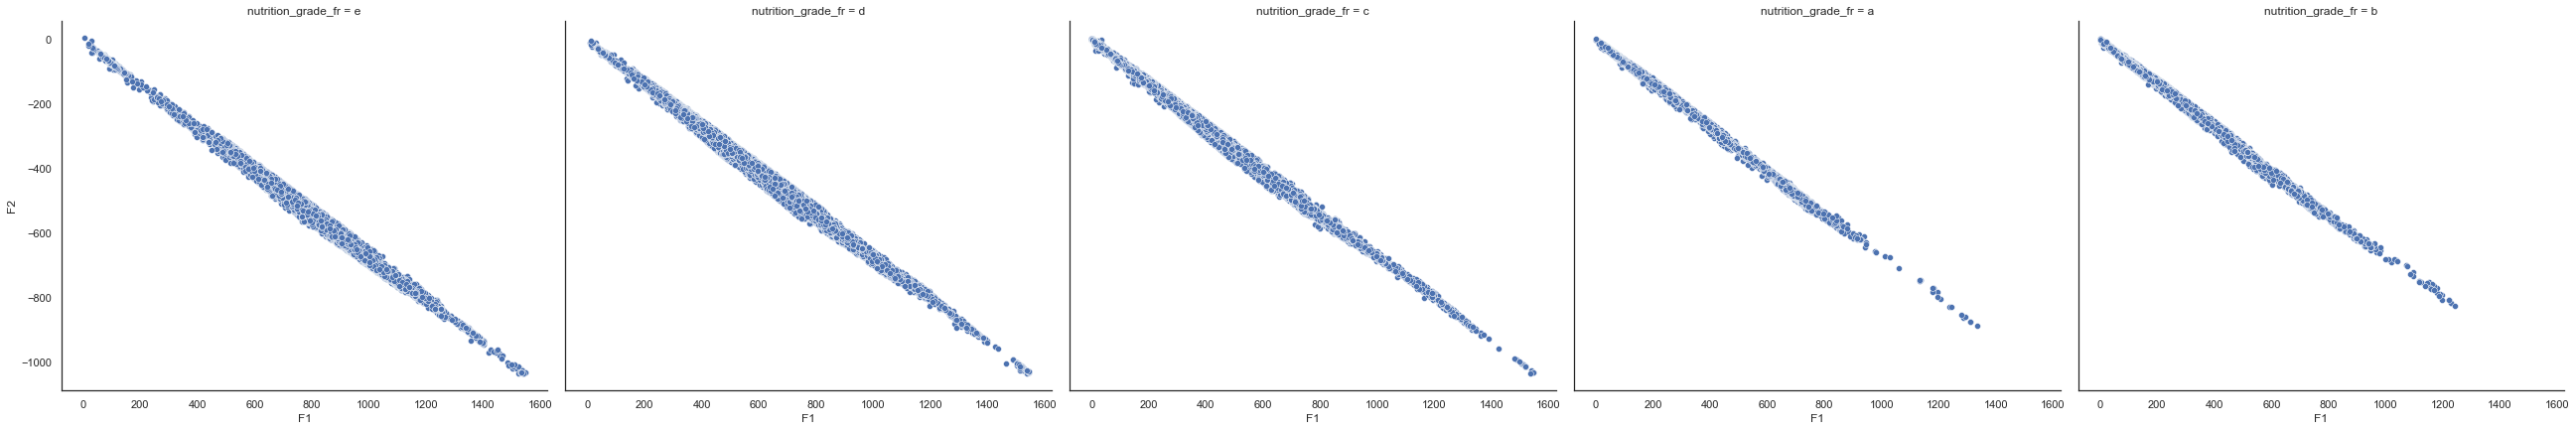

In [14]:
#Projection des invidus sur le premier plan factoriel, selon leur grade de nutrition
sns.relplot(x='F1',y='F2',data=openfood,col='nutrition_grade_fr',height=6,aspect=1.2,kind='scatter')

# Modèles supervisés

Je vais maintenant mettre en place deux modèles supervisé ayant pour but de prédire le grade nutritionnel d’un aliment à l’aide des deux premiers axes d’inertie : 

-Un KNN afin de prédire le grade de nutritions 

-Une réduction linéaire pour prédire le score de nutrition et en déduire le grade de nutrition 

Puis je comparerai les résultats de ces deux méthodes 

## Régréssion linéaire


In [15]:
#Séparation des données
xtrain, xtest, ytrain, ytest = train_test_split(openfood[['F1','F2']], openfood['nutrition-score-fr_100g'], train_size=0.8)

#Initialisation et entrainement du modèles
linear=LinearRegression()
linear.fit(xtrain,ytrain)

#Affichage du score
linear.score(xtrain,ytrain)



0.41066482344751687

In [16]:
linear.score(xtest,ytest)

0.40083419381062735

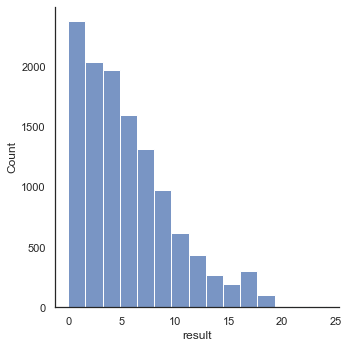

In [17]:
xtest['result']=abs(ytest-linear.predict(xtest))
sns.displot(xtest['result'],bins=15)

## KNN

In [18]:
#Séparation des données
xtrain, xtest, ytrain, ytest = train_test_split(openfood[['F1','F2']], openfood['nutrition_grade_fr'], train_size=0.8)

In [19]:
#Définition des paramètre a étudier pour le grid
param_grid={'n_neighbors' : np.arange(1,50),
            'metric':['euclidean','manhattan']}

#Initialisation et entrainement du modèle
grid=GridSearchCV(KNeighborsClassifier() , param_grid , cv=5)
grid.fit(xtrain,ytrain)

#Affichage des paramètres ayants les meilleurs résultats
grid.best_estimator_






KNeighborsClassifier(metric='manhattan', n_neighbors=1)

In [20]:
#Affichagee du score pour les données de train et set
knn=grid.best_estimator_
knn.score(xtrain,ytrain)
print(knn.score(xtrain,ytrain),knn.score(xtest,ytest))

0.9969015471744572 0.5319271175311885


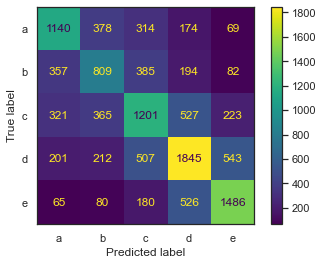

In [21]:
plot_confusion_matrix(knn,xtest,ytest)


Je représente les erreurs commises par score nutritionnel, à l’aide d’un scatterplot  

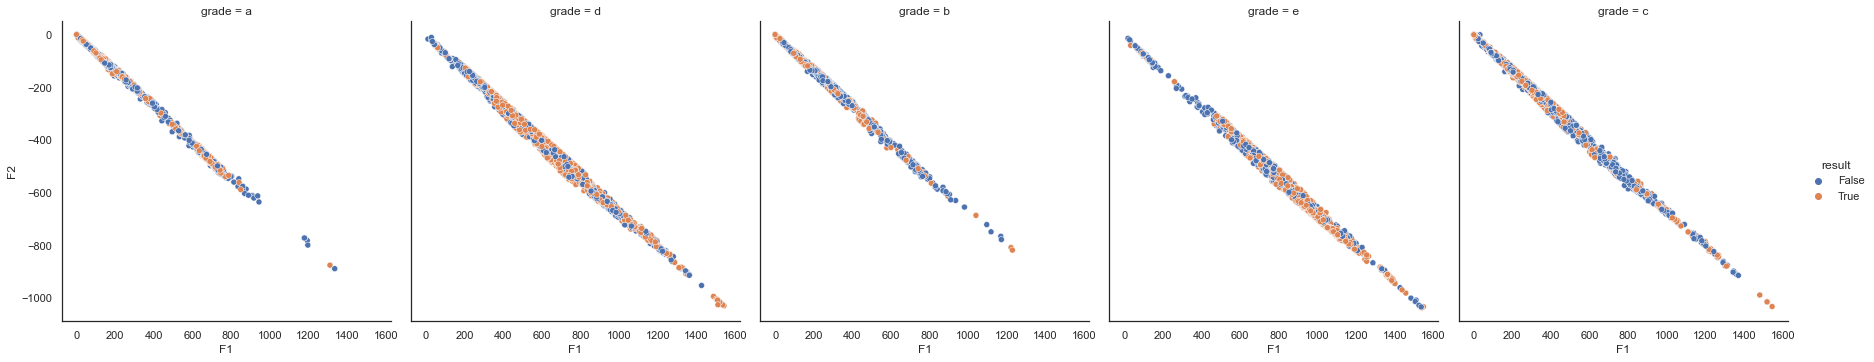

In [22]:
#Erreurs sur le données de test
xtest['result']=(ytest==knn.predict(xtest))
xtest['grade']=ytest
sns.relplot(x='F1',y='F2',data=xtest,col='grade',hue='result',kind='scatter')

# Conclusion 

  
Les deux modèles entrainés ne permettent pas de prédire d'un grade nutritionnel d'un produit à l'aide des données présentes dans le Data Frame 

-Le modèles de régression linéaire ne semble pas adapté pour répondre è la problématique 

-Le modèle de KNN est en underfitting et nécessiterait l'ajout de nouvelles variables dans le DataFrame (quantité de légumes présent... ) 